https://www.drivendata.org/competitions/42/page/73/

The task for this challenge is to recognize activities from the sensor data collected from participants. Here, "activity recognition" is the task of recognizing the posture and movements of the participants whose data was recorded, and our definition most closely aligns with the definition given by the accelerometer community. Three sensor modalities are provided for the prediction task:

1. Accelerometer - Sampled at 20 Hz;

2. RGB-D - Bounding box information given to preserve anonymity of participants;

3. Environmental - The values of passive infrared (PIR) sensors are given.

Lables of the dataset:

1. a_ascend - ascend stairs;
2. a_descend - descend stairs;
3. a_jump - jump;
4. a_loadwalk - walk with load;
5. a_walk - walk;
6. p_bent - bending;
7. p_kneel - kneeling;
8. p_lie - lying;
9. p_sit - sitting;
10. p_squat - squatting;
11. p_stand - standing;
12. t_bend - stand-to-bend;
13. t_kneel_stand - kneel-to-stand;
14. t_lie_sit - lie-to-sit;
15. t_sit_lie - sit-to-lie;
16. t_sit_stand - sit-to-stand;
17. t_stand_kneel - stand-to-kneel;
18. t_stand_sit - stand-to-sit;
19. t_straighten - bend-to-stand; and
20. t_turn - turn.

The prefix 'a' on a label indicates an ambulation activity (i.e. an activity requiring of continuing movement), the prefix 'p' indicate static postures (i.e. times when the participants are stationary), and the prefix 't' indicate posture-to-posture transitions. These labels are the target variables that are to be predicted in the challenge

***Each target is a vector of length 20 and aggregates the annotations of all annotators over one second non-overlapping windows. To understand the elements of the target vector, if, for a particular target vector, the activity a_walk is given a value of 0.05, this should be interpreted as meaning that on average the annotators marked 5% of the window as arising from walking. ***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import math

Training data is on the train folder which has many folders itself, one per sequence. Let's focus on the first of these folders (1st sequence)

In [2]:
targets_df = pd.read_csv('.\\public_data\\train\\00001\\targets.csv')
pirsensor_df = pd.read_csv('.\\public_data\\train\\00001\\pir.csv')
acceleration_df = pd.read_csv('.\\public_data\\train\\00001\\acceleration.csv')
vhallway_df = pd.read_csv('.\\public_data\\train\\00001\\video_hallway.csv')
vkitchen_df = pd.read_csv('.\\public_data\\train\\00001\\video_kitchen.csv')
vlivingroom_df = pd.read_csv('.\\public_data\\train\\00001\\video_living_room.csv')

# targets_df

I'll check the datasets now. In targets we see that we have some nulls at the beggining, we'll remove these.

In [3]:
print(targets_df.shape)
targets_df.isnull().sum()

(1824, 22)


start             0
end               0
a_ascend         71
a_descend        71
a_jump           71
a_loadwalk       71
a_walk           71
p_bent           71
p_kneel          71
p_lie            71
p_sit            71
p_squat          71
p_stand          71
t_bend           71
t_kneel_stand    71
t_lie_sit        71
t_sit_lie        71
t_sit_stand      71
t_stand_kneel    71
t_stand_sit      71
t_straighten     71
t_turn           71
dtype: int64

In [4]:
targets_df.dropna(axis=0, inplace=True)

In [5]:
print(targets_df.shape)

(1753, 22)


In [6]:
targets_df.head()

,start,end,a_ascend,a_descend,a_jump,a_loadwalk,a_walk,p_bent,p_kneel,p_lie,...,p_stand,t_bend,t_kneel_stand,t_lie_sit,t_sit_lie,t_sit_stand,t_stand_kneel,t_stand_sit,t_straighten,t_turn
44,44.0,45.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,45.0,46.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,46.0,47.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,47.0,48.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,48.0,49.0,0.0,0.0,0.0,0.0,0.366667,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3


Let's verify that the time is 1 second on all predictions:

In [8]:
def total_time(row):
    return row['end'] - row['start']

(targets_df.apply(total_time, axis=1)).value_counts()

1.0    1753
dtype: int64

# pir sensors (room sensors):

1. start - the start time of the PIR sensor (relative to the start of the sequence)
2. end - the end time of the PIR sensor (relative to the start of the sequence)
3. name - the name of the PIR sensor being activated (from the above list)
4. index - the index of the activated sensor from the pir_locations list starting at 0

In [9]:
pir_locations = ('bath', 'bed1', 'bed2', 'hall', 'kitchen', 'living', 'stairs', 'study', 'toilet')

In [10]:
print(pirsensor_df.shape)
print(pirsensor_df.isnull().sum())
pirsensor_df.head()

(115, 4)
start    0
end      0
name     0
index    0
dtype: int64


,start,end,name,index
0,4.608,6.556,study,7
1,20.657,22.924,stairs,6
2,15.873,26.559,study,7
3,23.775,28.951,kitchen,4
4,30.457,33.776,kitchen,4


In [11]:
pirsensor_df['index'].value_counts()

5    38
4    24
2    24
0    12
6     9
7     4
8     3
1     1
Name: index, dtype: int64

Some sensors overlap in time

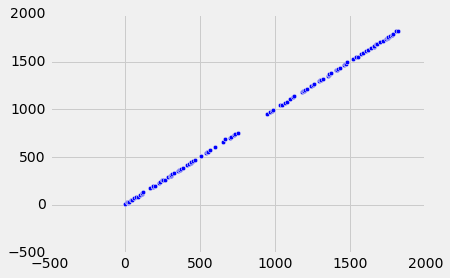

In [14]:
plt.scatter(pirsensor_df['start'],pirsensor_df['end'])

Sometimes the ovelap is because the subject stop moving in the room, some other times is just the transition from one room to another. For the former we'll add the room the subject is in but say there is no movement with another column (pig_movement). Fot the latter we'll ...

We can join this data to know what sensor was up during the measure. There are several posibilites on how the sensors recorded the data:

1. sensor started but didn't finish the seg
2. the sensor was on the whole seg
3. sensor started and finisht during the seg
4. sensor started during the seg

We'll merge dataframes and we'll take this into account by adding another column (numbers 1 to 4)

In [ ]:
def total_time(row):
    return row['end'] - row['start']

pirsensor_df['total_time'] = pirsensor_df.apply(total_time, axis=1)

pirsensor_df['start_new_int'] = pirsensor_df['start'].map(lambda x: math.modf(x)[1])
pirsensor_df['end_new_int'] = pirsensor_df['end'].map(lambda x: math.modf(x)[1])

pirsensor_df['start_partial'] = pirsensor_df['start'].map(lambda x: 0 if math.modf(x)[0]<0.1 else 1)
pirsensor_df['end_partial'] = pirsensor_df['end'].map(lambda x: 1 if math.modf(x)[0]<0.9 else 0)

In [ ]:
pirsensor_df.head(20)

In [ ]:
pirsensor_df.loc[pirsensor_df.start_new_int==190,:]

I want to merge this df with targets, and I want to keep index, total_time, and a column called partial which will be 1 if the second was partial (either start or end there)

In [ ]:
targets_df['pir_sensor'] = np.nan
targets_df['pir_sensor'] = pd.to_numeric(targets_df['pir_sensor'], errors='coerce')
targets_df['pir_total_time'] = np.nan
targets_df['pir_partial'] = np.nan # 0 if it was less that 0.2 seconds, 1 otherwise
targets_df['pir_movement'] = 0
targets_df['pir_several'] = 0

We are going to add a column where we say if 2 sensors where picking things up at the same time

In [ ]:
all_segs = []
for row in pirsensor_df.iterrows():
    start = row[1].start_new_int
    end = row[1].end_new_int
           
    # Calculate all the seconds
    for sec in range(int(start), int(end)+1):
        all_segs.append(sec)
    
import collections
dups = [item for item, count in collections.Counter(all_segs).items() if count > 1]
print (dups)

for i in dups:
    targets_df.loc[i, 'pir_several'] = 1

Let's populate targets_df with all the info coming from the sensors

In [ ]:
for row in pirsensor_df.iterrows():
    start = row[1].start_new_int
    end = row[1].end_new_int
           
    # Calculate all the seconds
    for sec in range(int(start), int(end)+1):
        #print(row[1])
        targets_df.loc[targets_df.start==sec, 'pir_sensor'] = row[1]['index']
        targets_df.loc[targets_df.start==sec, 'pir_total_time'] = row[1].total_time
        targets_df.loc[targets_df.start==sec, 'pir_sensor_room'] = row[1]['name']
        targets_df.loc[targets_df.start==sec, 'pir_movement'] = 1
        if sec == start:
            targets_df.loc[targets_df.start==sec, 'pir_partial'] = row[1].start_partial
        elif sec == end:
            targets_df.loc[targets_df.start==sec, 'pir_partial'] = row[1].end_partial
        else:
            targets_df.loc[targets_df.start==sec, 'pir_partial'] = 0

I need to fill up the rooms when the person is not moving my checking the last room we have info about

In [ ]:
for row in targets_df.iterrows():
    if pd.notnull(row[1].pir_sensor):
        last_sensor = row[1].pir_sensor
        last_sensor_room = row[1].pir_sensor_room
    else:
        targets_df.loc[row[0], 'pir_sensor'] = last_sensor
        targets_df.loc[row[0], 'pir_sensor_room'] = last_sensor_room

# Acelerometers

Participants wore a device equipped with a tri-axial accelerometer on the dominant wrist, attached using a strap. The device wirelessly transmits data using the standard to several access points (receivers) positioned within the house. The outputs of these sensors are a continuous numerical stream of the accelerometer readings (units of g). Accompanying the accelerometer readings are the that were recorded by each access point (in units of dBm), and these data will be informative for indoor localization. The accelerometers record data at 20 Hz, and the maximum accelerometer range is 8 g. Note: if the signal path between the accelerometer and the access point is shielded, this will result in loss of data.

1. t: this is the time of the recording (relative to the start of the sequence)
2. x/y/z: these are the acceleration values recorded on the x/y/z axes of the accelerometer.
3. Kitchen_AP/Lounge_AP/Upstairs_AP/Study_AP: these specify the received signal strength indicator (RSSI) of the acceleration signal as received by the access kitchen/lounge (ie living room)/upstairs/study access points. Empty values indicate that the access point did not receive the packet.

In [ ]:
print(acceleration_df.shape)
print(acceleration_df.isnull().sum())
acceleration_df.head(10)

In [ ]:
upstairs = acceleration_df.Upstairs_AP.dropna().value_counts().sort_index()
lounge = acceleration_df.Lounge_AP.dropna().value_counts().sort_index()
kitchen = acceleration_df.Kitchen_AP.dropna().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((1,1), (0, 0))
ax1.set(xlabel='time' , ylabel='dBm', title='Acelerometers over time',xticks=(np.arange(0, 36000, 8000.0)))
ax1.scatter(acceleration_df.index,acceleration_df.Upstairs_AP,color='g',marker='x',alpha=0.6)
ax1.scatter(acceleration_df.index,acceleration_df.Lounge_AP,color='r',marker='x',alpha=0.6)
ax1.scatter(acceleration_df.index,acceleration_df.Kitchen_AP,color='b',marker='x',alpha=0.6)
ax1.scatter(acceleration_df.index,acceleration_df.Study_AP,color='m',marker='x',alpha=0.6)
ax1.legend(loc=2,prop={'size':9})
plt.tight_layout()
plt.show()

There are sevelar measures in every second. We need to group this somehow. We'll do this by taking the mean and sd

In [ ]:
acceleration_df.loc[acceleration_df.t>17].head(10)

In [ ]:
acceleration_df["start"] = acceleration_df.t.map(lambda x: math.modf(x)[1])

In [ ]:
gb_acc = acceleration_df.groupby('start')
acc_mean = gb_acc['x','y','z','Kitchen_AP','Lounge_AP','Upstairs_AP','Study_AP'].aggregate(np.mean)
acc_std = gb_acc['x','y','z','Kitchen_AP','Lounge_AP','Upstairs_AP','Study_AP'].aggregate(np.std)

acceleration_sec_df = pd.DataFrame()
acceleration_sec_df['start'] = acc_mean.index
acceleration_sec_df['acc_x_mean'] = acc_mean['x'].values
acceleration_sec_df['acc_y_mean'] = acc_mean['y'].values
acceleration_sec_df['acc_z_mean'] = acc_mean['z'].values
acceleration_sec_df['acc_x_std'] = acc_std['x'].values
acceleration_sec_df['acc_y_std'] = acc_std['y'].values
acceleration_sec_df['acc_z_std'] = acc_std['z'].values
acceleration_sec_df['acc_kitchen_mean'] = acc_mean['Kitchen_AP'].values
acceleration_sec_df['acc_lounge_mean'] = acc_mean['Lounge_AP'].values
acceleration_sec_df['acc_upstairs_mean'] = acc_mean['Upstairs_AP'].values
acceleration_sec_df['acc_study_mean'] = acc_mean['Study_AP'].values
acceleration_sec_df['acc_kitchen_std'] = acc_std['Kitchen_AP'].values
acceleration_sec_df['acc_lounge_std'] = acc_std['Lounge_AP'].values
acceleration_sec_df['acc_upstairs_std'] = acc_std['Upstairs_AP'].values
acceleration_sec_df['acc_study_std'] = acc_std['Study_AP'].values

acceleration_sec_df.head()

In [ ]:
all_df = pd.merge(targets_df, acceleration_sec_df, on='start', how='left')

In [ ]:
all_df.head()

# VIDEO_

vhallway_df, 
vkitchen_df, 
vlivingroom_df.

1. t: The current time (relative to the start of the sequence)
2. centre_2d_x/centre_2d_y: The x- and y-coordinates of the center of the 2D bounding box.
3. bb_2d_br_x/bb_2d_br_y: The x and y coordinates of the bottom right (br) corner of the 2D bounding box
4. bb_2d_tl_x/bb_2d_tl_y: The x and y coordinates of the top left (tl) corner of the 2D bounding box
5. centre_3d_x/centre_3d_y/centre_3d_z: the x, y and z coordinates for the center of the 3D bounding box
6. bb_3d_brb_x/bb_3d_brb_y/bb_3d_brb_z: the x, y, and z coordinates for the bottom right back corner of the 3D bounding box
7. bb_3d_flt_x/bb_3d_flt_y/bb_3d_flt_z: the x, y, and z coordinates of the front left top corner of the 3D bounding box.


Per video csv I'll check nulls and I'll group by second aggregating by mean and std. I'll add the results to the main table (all_df)

*** vhallway_df ***

In [ ]:
print(vhallway_df.shape)
print(vhallway_df.isnull().sum())
vhallway_df.head()

In [ ]:
video_columns = list(vhallway_df.columns)
video_columns.remove('t')
video_columns

In [ ]:
vhallway_df["start"] = vhallway_df.t.map(lambda x: math.modf(x)[1])

gb_vid = vhallway_df.groupby('start')
v_mean = gb_vid[video_columns].aggregate(np.mean)
v_std = gb_vid[video_columns].aggregate(np.std)

video_df = pd.DataFrame()
(video_df)['start'] = v_mean.index
print(video_df.shape)
for col in video_columns:
    video_df['vid_hall_'+col+'_mean'] = v_mean[col].values
    video_df['vid_hall_'+col+'_std'] = v_std[col].values
    
all_df = pd.merge(all_df, video_df, on='start', how='left')

*** vkitchen_df ***

In [ ]:
print(vkitchen_df.shape)
print(vkitchen_df.isnull().sum())
vkitchen_df.head()

In [ ]:
vkitchen_df["start"] = vkitchen_df.t.map(lambda x: math.modf(x)[1])

gb_vid = vkitchen_df.groupby('start')
v_mean = gb_vid[video_columns].aggregate(np.mean)
v_std = gb_vid[video_columns].aggregate(np.std)

video_df = pd.DataFrame()
video_df['start'] = v_mean.index
print(video_df.shape)
for col in video_columns:
    video_df['vid_kit_'+col+'_mean'] = v_mean[col].values
    video_df['vid_kit_'+col+'_std'] = v_std[col].values
    
all_df = pd.merge(all_df, video_df, on='start', how='left') 

*** vlivingroom_df ***

In [ ]:
print(vlivingroom_df.shape)
print(vlivingroom_df.isnull().sum())
vlivingroom_df.head()

In [ ]:
vlivingroom_df["start"] = vlivingroom_df.t.map(lambda x: math.modf(x)[1])

gb_vid = vlivingroom_df.groupby('start')
v_mean = gb_vid[video_columns].aggregate(np.mean)
v_std = gb_vid[video_columns].aggregate(np.std)

video_df = pd.DataFrame()
video_df['start'] = v_mean.index
print(video_df.shape)
for col in video_columns:
    video_df['vid_liv_'+col+'_mean'] = v_mean[col].values
    video_df['vid_liv_'+col+'_std'] = v_std[col].values
    
all_df = pd.merge(all_df, video_df, on='start', how='left')

In [ ]:
all_df.shape

In [ ]:
import missingno as msno
msno.matrix(all_df)

In [ ]:
all_df.head()

In [ ]:
all_df.drop(['start','end'], axis=1, inplace= True)

In [ ]:
print(all_df.shape)
all_df.head()